In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.optimizers import Adam

import os
import cv2
import random
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt

# ignore information messgaes from tensorflow, but we will receieve error messages
os.environ['TFF_CPP_MIN_LOG_LEVEL'] = '2'

%matplotlib inline


# Loading Data

In [2]:
TRAIN_DATA_DIR = '../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
TEST_DATA_DIR = '../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'


CATEGORIES = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'space', 'del', 'nothing' ]

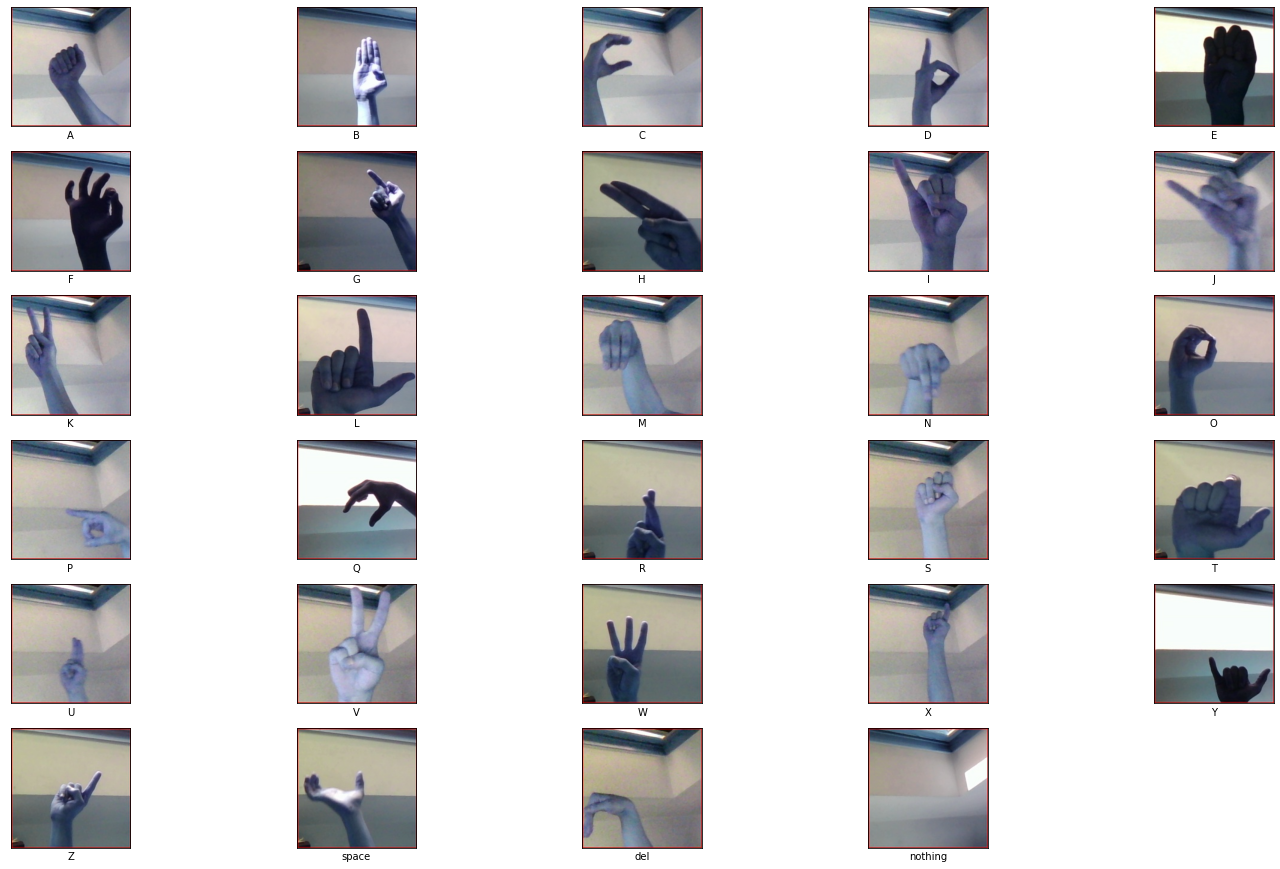

In [3]:
plt.figure(figsize=(20,20))
i=0
for c in CATEGORIES:  
    path = os.path.join(TRAIN_DATA_DIR,c)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.subplot(10,5,i+1)
        plt.imshow(img_array)
        plt.xlabel(c)
        plt.xticks([])
        plt.yticks([])
        i += 1
        break

plt.tight_layout()        
plt.show()

In [4]:
IMG_SIZE = 32

training_data = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append([img_resized, class_num])
        except WException as e:
            pass
        
print(len(training_data))

100%|██████████| 3000/3000 [00:13<00:00, 214.78it/s]

87000


In [9]:
test_data = []

for c in tqdm(CATEGORIES):
    if c == 'del':
        continue
    class_num = CATEGORIES.index(c) 
    img = os.path.join(TEST_DATA_DIR, c+'_test.jpg') 
    
    try:
        img_array = cv2.imread(img) 
        img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
        test_data.append([img_resized, class_num])
    except WException as e:
        pass
        
print(len(test_data))

100%|██████████| 29/29 [00:00<00:00, 533.02it/s]

28


In [10]:
random.shuffle(training_data)
random.shuffle(test_data)

In [16]:
X_train = []
Y_train = []

for img, label in training_data:
    X_train.append(img)
    Y_train.append(label)
    
X_train = np.array(X_train).astype('float32').reshape(-1,IMG_SIZE,IMG_SIZE,3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_train= (87000, 32, 32, 3) Y_train= (87000,)


In [17]:
X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)

print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")

X_test= (28, 32, 32, 3) Y_test= (28,)


In [24]:
X_train_norm = X_train.astype('float32')/255.0

# VGG-16 Architecture

In [22]:
model = Sequential()
model.add(Conv2D(input_shape=(IMG_SIZE,IMG_SIZE,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())

model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=29, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)         2

In [25]:
model.compile(
    optimizer=Adam(lr=0.001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

# Model Training

In [28]:
h = model.fit(x=X_train_norm, y=Y_train, epochs=3, shuffle = True, validation_split=0.1, batch_size=128)

Epoch 1/3
612/612 [==============================] - 221s 361ms/step - loss: 3.3675 - accuracy: 0.0330 - val_loss: 3.3675 - val_accuracy: 0.0328
Epoch 2/3
612/612 [==============================] - 218s 357ms/step - loss: 3.3675 - accuracy: 0.0325 - val_loss: 3.3675 - val_accuracy: 0.0330
Epoch 3/3
612/612 [==============================] - 218s 357ms/step - loss: 3.3675 - accuracy: 0.0330 - val_loss: 3.3675 - val_accuracy: 0.0337


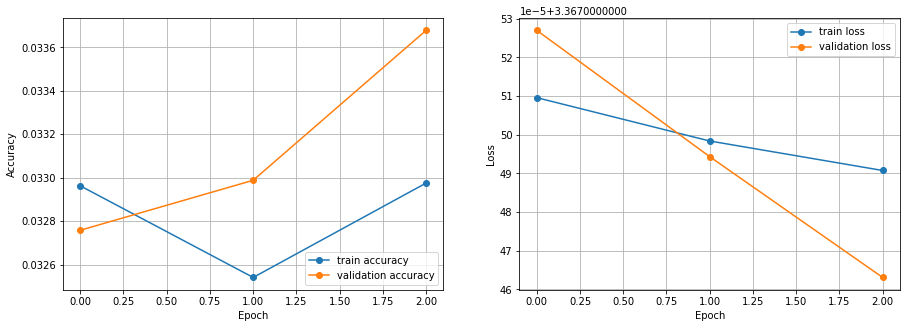

In [29]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], 'o-', label='train accuracy')
plt.plot(h.history['val_accuracy'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], 'o-', label='train loss')
plt.plot(h.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [30]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)

1/1 [==============================] - 0s 446ms/step - loss: 3.3673 - accuracy: 0.0357

Test Accuracy: 0.0357142873108387

Test Loss: 3.3673489093780518
